# Scenario 2 (High Density)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

## Config

In [2]:
inputFile = '2kr-scalars-50rep.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

showConstructedDF = True

# Fitting
distsFit = ['norm', 'uniform'] # Distributions to fit
distsParams = [(), ()] # Distributions params
outlierStddevDistance = 3 # Outliers identification

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
scatterShowLines = False
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.activityTime:last']
# Residuals to compute
residualNames = [
    ('coveredUsersPercent', 'percentage of covered users (residuals)'),
    ('collisions', 'total number of collisions (residuals)'),
    ('activityTime', 'total broadcast time (residuals)'),
]

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

# Scatter plot whitelists
configsShown = range(0, configsCount)
repetitionsShown = range(3, repetitionsCount)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 50


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

## Compute residuals

In [6]:
# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)
scalars_wide['coveredUsersPercentMean'] = scalars_wide.groupby(factors)['coveredUsersPercent'].transform('mean')
scalars_wide['coveredUsersPercentResidual'] = scalars_wide['coveredUsersPercent'] - scalars_wide['coveredUsersPercentMean']

# collisions
scalars_wide['collisionsMean'] = scalars_wide.groupby(factors)['Floorplan.collisions:sum'].transform('mean')
scalars_wide['collisionsResidual'] = scalars_wide['Floorplan.collisions:sum'] - scalars_wide['collisionsMean']

# activity (broadcast) time
scalars_wide['activityTimeMean'] = scalars_wide.groupby(factors)['Floorplan.activityTime:last'].transform('mean')
scalars_wide['activityTimeResidual'] = scalars_wide['Floorplan.activityTime:last'] - scalars_wide['activityTimeMean']

## Constructed DataFrame

In [7]:
if showConstructedDF:
    display(scalars_wide.describe())
    display(scalars_wide[(totalSims//2)-10:(totalSims//2)+10])
else:
    print('Skipping...')

qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,Floorplan.activityTime:last,coveredUsersPercent,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,activityTimeMean,activityTimeResidual
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.0,800.00000,800.000000,800.000000,800.000000,800.000000,8.000000e+02,800.000000,8.000000e+02,800.000000,8.000000e+02
mean,7.500000,24.500000,20.000000,3.000000,3.000000,3.000000,500.0,443.23375,883.762500,48.940000,0.888244,0.888244,9.381385e-17,883.762500,-1.875833e-14,48.940000,-2.398082e-16
std,4.612656,14.439897,10.006256,2.001251,2.001251,2.001251,0.0,64.12895,649.926539,38.182506,0.128515,0.090039,9.170101e-02,635.208995,1.375283e+02,35.894353,1.301918e+01
min,0.000000,0.000000,10.000000,1.000000,1.000000,1.000000,500.0,18.00000,7.000000,6.000000,0.036072,0.689339,-9.317836e-01,138.740000,-6.174000e+02,9.720000,-1.038400e+02
25%,3.750000,12.000000,10.000000,1.000000,1.000000,1.000000,500.0,417.00000,330.000000,19.000000,0.835671,0.851553,-1.477956e-02,328.670000,-4.078000e+01,22.705000,-3.700000e+00
50%,7.500000,24.500000,20.000000,3.000000,3.000000,3.000000,500.0,463.00000,663.000000,35.000000,0.927856,0.878818,4.609218e-03,680.400000,2.260000e+00,34.970000,-3.200000e-01
75%,11.250000,37.000000,30.000000,5.000000,5.000000,5.000000,500.0,492.00000,1362.250000,64.250000,0.985972,0.968828,3.241483e-02,1312.180000,4.298500e+01,64.005000,4.060000e+00
max,15.000000,49.000000,30.000000,5.000000,5.000000,5.000000,500.0,499.00000,2452.000000,191.000000,1.000000,0.999679,2.465331e-01,2080.400000,6.199800e+02,129.840000,6.116000e+01


qname,config,repetition,R,T,m,D,Floorplan.userCount,Floorplan.coveredUsers:sum,Floorplan.collisions:sum,Floorplan.activityTime:last,coveredUsersPercent,coveredUsersPercentMean,coveredUsersPercentResidual,collisionsMean,collisionsResidual,activityTimeMean,activityTimeResidual
run,,,,,,,,,,,,,,,,,
HighDensity2kr-740-20210201-18:20:28-12370,7.0,40.0,10.0,5.0,5.0,5.0,500.0,499.0,408.0,111.0,1.000000,0.999679,0.000321,402.30,5.70,103.86,7.14
HighDensity2kr-741-20210201-18:20:28-12370,7.0,41.0,10.0,5.0,5.0,5.0,500.0,499.0,432.0,125.0,1.000000,0.999679,0.000321,402.30,29.70,103.86,21.14
HighDensity2kr-742-20210201-18:20:28-12370,7.0,42.0,10.0,5.0,5.0,5.0,500.0,499.0,395.0,118.0,1.000000,0.999679,0.000321,402.30,-7.30,103.86,14.14
HighDensity2kr-743-20210201-18:20:29-12370,7.0,43.0,10.0,5.0,5.0,5.0,500.0,499.0,381.0,108.0,1.000000,0.999679,0.000321,402.30,-21.30,103.86,4.14
HighDensity2kr-744-20210201-18:20:29-12370,7.0,44.0,10.0,5.0,5.0,5.0,500.0,499.0,363.0,110.0,1.000000,0.999679,0.000321,402.30,-39.30,103.86,6.14
HighDensity2kr-745-20210201-18:20:30-12370,7.0,45.0,10.0,5.0,5.0,5.0,500.0,498.0,419.0,109.0,0.997996,0.999679,-0.001683,402.30,16.70,103.86,5.14
HighDensity2kr-746-20210201-18:20:30-12370,7.0,46.0,10.0,5.0,5.0,5.0,500.0,499.0,423.0,90.0,1.000000,0.999679,0.000321,402.30,20.70,103.86,-13.86
HighDensity2kr-747-20210201-18:20:30-12370,7.0,47.0,10.0,5.0,5.0,5.0,500.0,499.0,389.0,101.0,1.000000,0.999679,0.000321,402.30,-13.30,103.86,-2.86
HighDensity2kr-748-20210201-18:20:31-12370,7.0,48.0,10.0,5.0,5.0,5.0,500.0,499.0,350.0,79.0,1.000000,0.999679,0.000321,402.30,-52.30,103.86,-24.86


## Residual distributions (histograms)

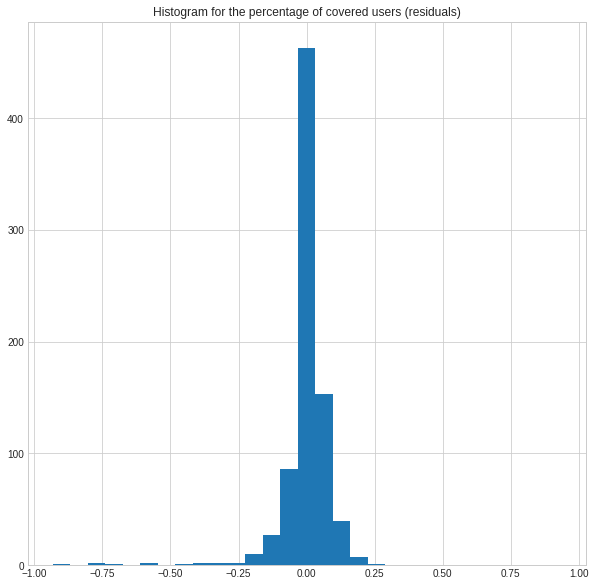

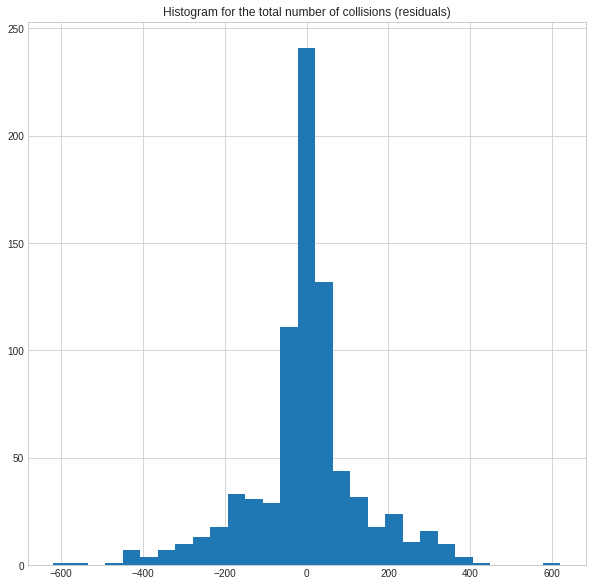

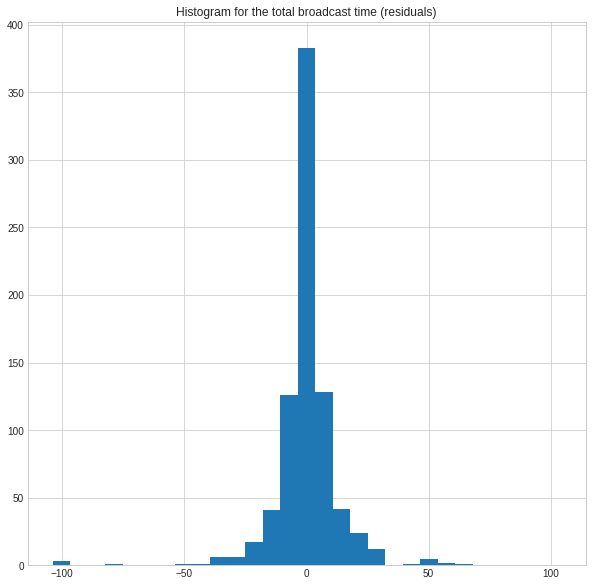

In [8]:
for varname, vardesc in residualNames:
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    minval = scalars_wide[varname + 'Residual'].min()
    maxval = scalars_wide[varname + 'Residual'].max()
    if histCenter:
        limit = max(abs(minval), abs(maxval))
        minval = -limit
        maxval = limit
    plt.hist(scalars_wide[varname + 'Residual'].values.tolist(), bins=np.linspace(minval, maxval, histBinNum))
    plt.title('Histogram for the ' + vardesc)
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-hist.png')
    plt.show()

## Distribution fitting

Trying to fit to a norm distribution:


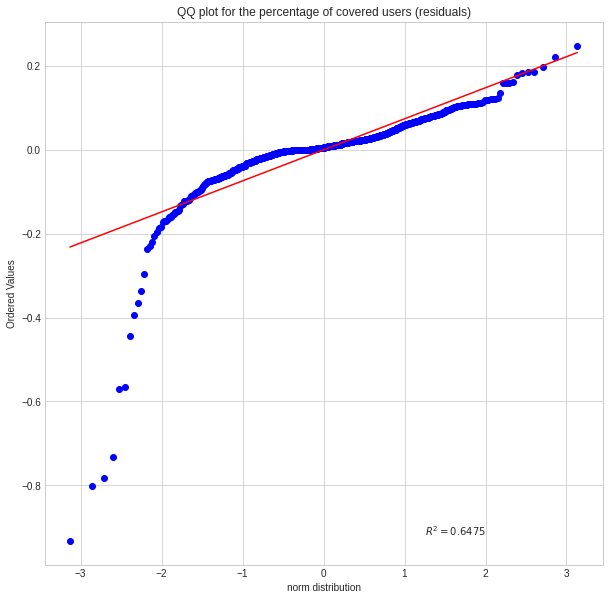

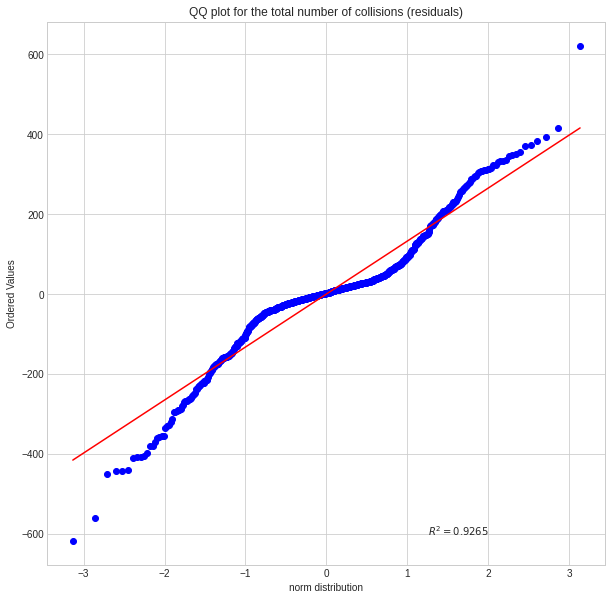

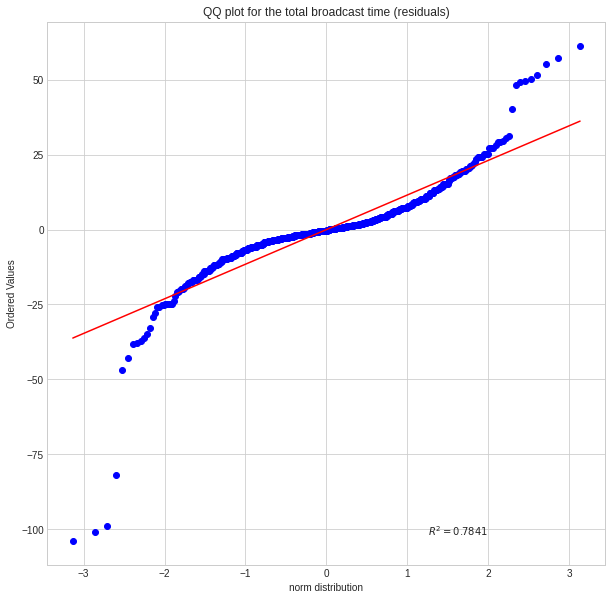

Trying to fit to a uniform distribution:


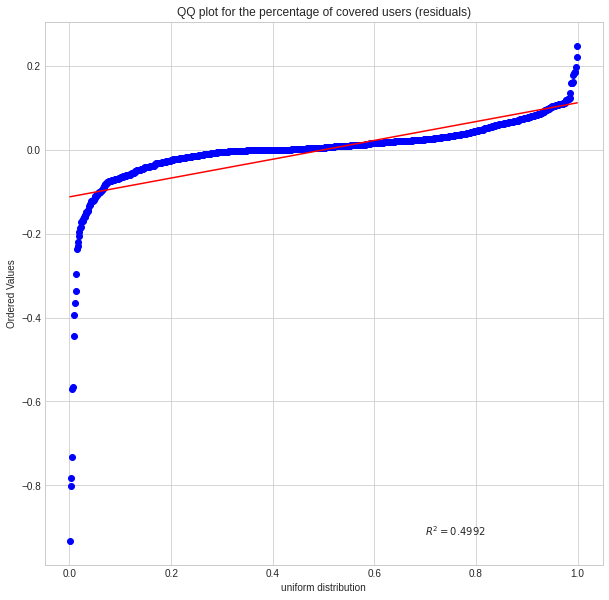

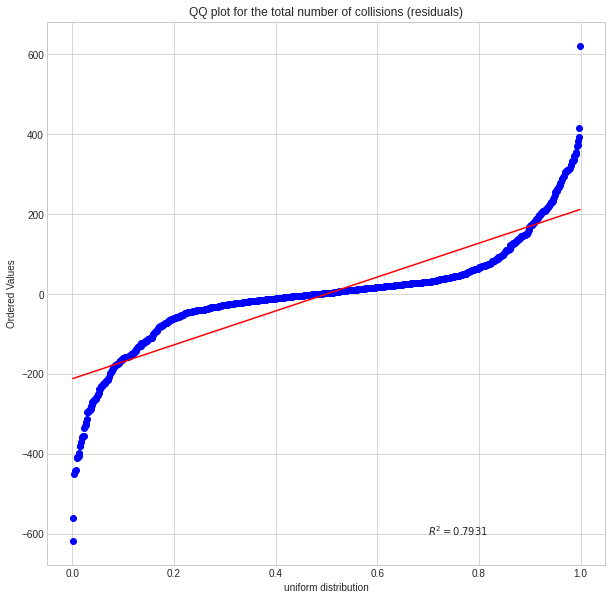

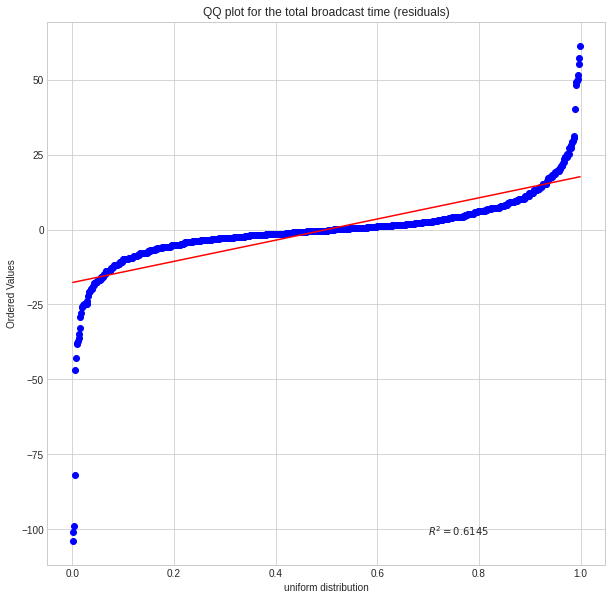

In [9]:
for distribution, params in zip(distsFit, distsParams):
    print('Trying to fit to a', distribution + ('({})'.format(', '.join(map(str, params))) if len(params) > 0 else ''), 'distribution:')
    for varname, vardesc in residualNames:
        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        residuals = scalars_wide[varname + 'Residual'].values.tolist()
        result, line = stats.probplot(residuals, dist=distribution, sparams=params, plot=plt, rvalue=True)
        #osm, _ = result
        #slope, intercept, _ = line
        plt.title("QQ plot for the " + vardesc)
        plt.xlabel(distribution + " distribution")
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + varname + '-' + distribution + '-fit.png')
        plt.show()

### Outliers

In [10]:
for varname, vardesc in residualNames:
    print('Outliers for the ' + vardesc)
    stddev = scalars_wide[varname + 'Residual'].std()
    limit = outlierStddevDistance*stddev
    print('total mean:', scalars_wide[varname + 'Mean'].mean())
    print('stddev:', stddev)
    print(str(outlierStddevDistance) + '*stddev:', limit)
    outliers = scalars_wide[np.abs(scalars_wide[varname + 'Residual']) > limit]
    display(outliers[['config', 'repetition', *factors, varname + 'Residual', varname + 'Mean']])

Outliers for the percentage of covered users (residuals)
total mean: 0.888243987975959
stddev: 0.09170101257799776
3*stddev: 0.27510303773399325


qname,config,repetition,R,T,m,D,coveredUsersPercentResidual,coveredUsersPercentMean
run,,,,,,,,
HighDensity2kr-1-20210201-18:17:25-12370,0.0,1.0,10.0,1.0,1.0,1.0,-0.337595,0.856633
HighDensity2kr-28-20210201-18:17:30-12370,0.0,28.0,10.0,1.0,1.0,1.0,-0.393707,0.856633
HighDensity2kr-443-20210201-18:19:16-12370,4.0,43.0,10.0,5.0,1.0,1.0,-0.444289,0.863126
HighDensity2kr-601-20210201-18:19:56-12370,5.0,1.0,10.0,5.0,1.0,5.0,-0.569299,0.881924
HighDensity2kr-610-20210201-18:19:58-12370,5.0,10.0,10.0,5.0,1.0,5.0,-0.781723,0.881924
HighDensity2kr-634-20210201-18:20:02-12370,5.0,34.0,10.0,5.0,1.0,5.0,-0.731623,0.881924
HighDensity2kr-646-20210201-18:20:04-12370,5.0,46.0,10.0,5.0,1.0,5.0,-0.801764,0.881924
HighDensity2kr-520-20210201-18:19:32-12370,6.0,20.0,10.0,5.0,5.0,1.0,-0.931784,0.967856
HighDensity2kr-51-20210201-18:17:34-12370,8.0,1.0,30.0,1.0,1.0,1.0,-0.296553,0.689339


Outliers for the total number of collisions (residuals)
total mean: 883.7625000000024
stddev: 137.52832308132724
3*stddev: 412.58496924398173


qname,config,repetition,R,T,m,D,collisionsResidual,collisionsMean
run,,,,,,,,
HighDensity2kr-520-20210201-18:19:32-12370,6.0,20.0,10.0,5.0,5.0,1.0,-617.40,635.40
HighDensity2kr-279-20210201-18:18:32-12370,9.0,29.0,30.0,1.0,1.0,5.0,-443.90,1240.90
HighDensity2kr-281-20210201-18:18:32-12370,9.0,31.0,30.0,1.0,1.0,5.0,-440.90,1240.90
HighDensity2kr-155-20210201-18:18:03-12370,10.0,5.0,30.0,1.0,5.0,1.0,619.98,1526.02
HighDensity2kr-182-20210201-18:18:10-12370,10.0,32.0,30.0,1.0,5.0,1.0,-443.02,1526.02
HighDensity2kr-195-20210201-18:18:14-12370,10.0,45.0,30.0,1.0,5.0,1.0,-451.02,1526.02
HighDensity2kr-196-20210201-18:18:14-12370,10.0,46.0,30.0,1.0,5.0,1.0,415.98,1526.02
HighDensity2kr-561-20210201-18:19:45-12370,14.0,11.0,30.0,5.0,5.0,1.0,-561.08,1673.08


Outliers for the total broadcast time (residuals)
total mean: 48.94000000000042
stddev: 13.019184842664298
3*stddev: 39.05755452799289


qname,config,repetition,R,T,m,D,activityTimeResidual,activityTimeMean
run,,,,,,,,
HighDensity2kr-249-20210201-18:18:27-12370,1.0,49.0,10.0,1.0,1.0,5.0,55.30,55.70
HighDensity2kr-406-20210201-18:19:09-12370,4.0,6.0,10.0,5.0,1.0,1.0,49.66,101.34
HighDensity2kr-407-20210201-18:19:09-12370,4.0,7.0,10.0,5.0,1.0,1.0,51.66,101.34
HighDensity2kr-601-20210201-18:19:56-12370,5.0,1.0,10.0,5.0,1.0,5.0,-46.84,129.84
HighDensity2kr-604-20210201-18:19:57-12370,5.0,4.0,10.0,5.0,1.0,5.0,40.16,129.84
HighDensity2kr-610-20210201-18:19:58-12370,5.0,10.0,10.0,5.0,1.0,5.0,-100.84,129.84
HighDensity2kr-612-20210201-18:19:58-12370,5.0,12.0,10.0,5.0,1.0,5.0,48.16,129.84
HighDensity2kr-622-20210201-18:20:00-12370,5.0,22.0,10.0,5.0,1.0,5.0,-42.84,129.84
HighDensity2kr-623-20210201-18:20:00-12370,5.0,23.0,10.0,5.0,1.0,5.0,57.16,129.84


## Independency test

qname,config,R,T,m,D
run,,,,,
HighDensity2kr-0-20210201-18:17:25-12370,0.0,10.0,1.0,1.0,1.0
HighDensity2kr-200-20210201-18:18:15-12370,1.0,10.0,1.0,1.0,5.0
HighDensity2kr-100-20210201-18:17:42-12370,2.0,10.0,1.0,5.0,1.0
HighDensity2kr-300-20210201-18:18:35-12370,3.0,10.0,1.0,5.0,5.0
HighDensity2kr-400-20210201-18:19:08-12370,4.0,10.0,5.0,1.0,1.0
HighDensity2kr-600-20210201-18:19:56-12370,5.0,10.0,5.0,1.0,5.0
HighDensity2kr-500-20210201-18:19:24-12370,6.0,10.0,5.0,5.0,1.0
HighDensity2kr-700-20210201-18:20:12-12370,7.0,10.0,5.0,5.0,5.0
HighDensity2kr-50-20210201-18:17:34-12370,8.0,30.0,1.0,1.0,1.0


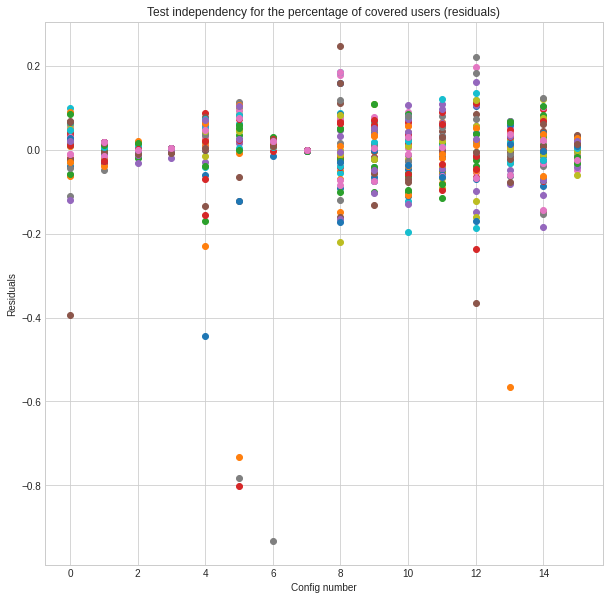

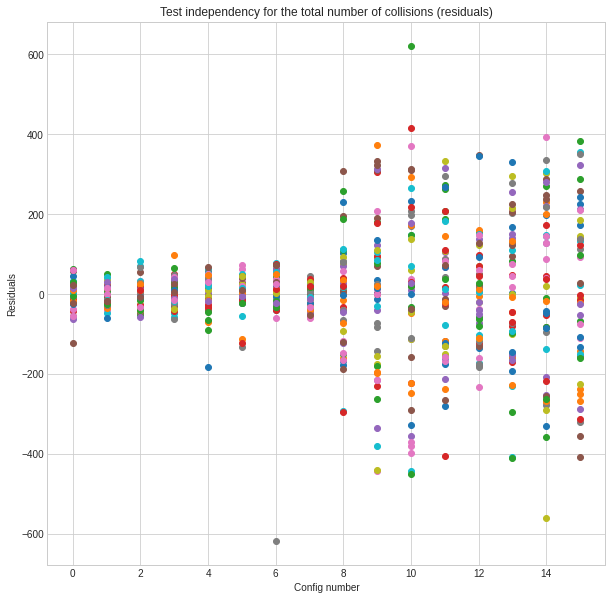

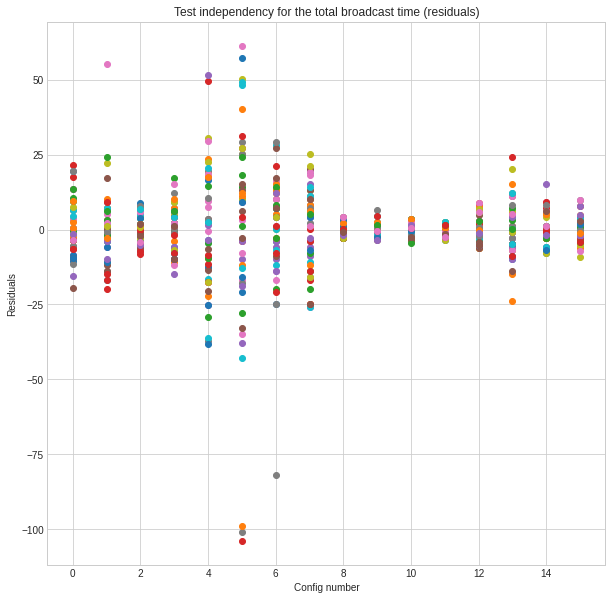

In [11]:
display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config.isin(configsShown))][['config', *factors]])
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append([config] * len(repetitionsShown))
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test independency for the " + vardesc)
    plt.xlabel("Config number")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-independency.png')
    plt.show()

## Finite variance test

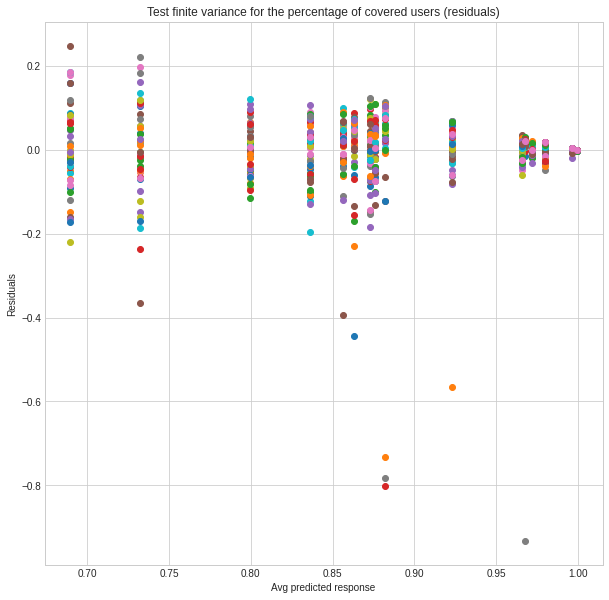

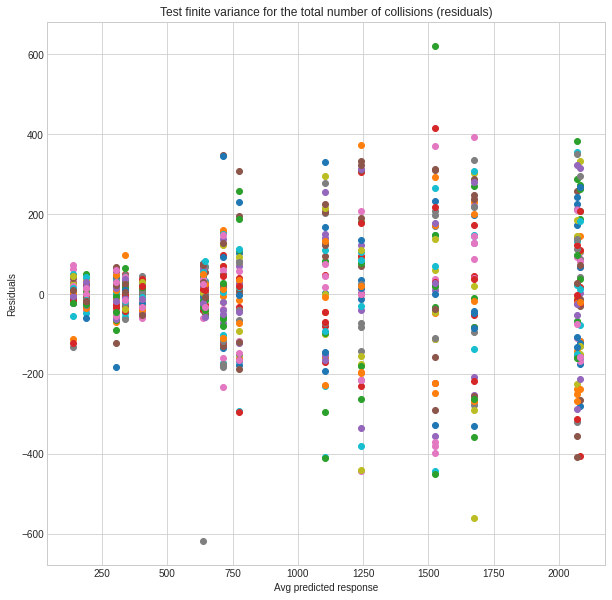

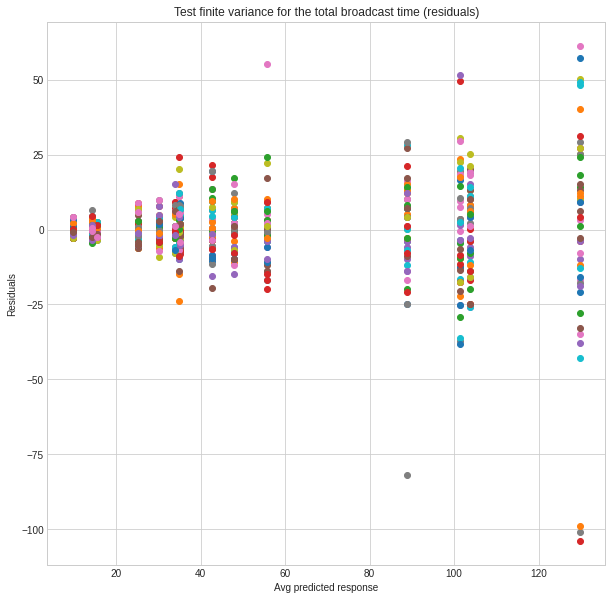

In [12]:
for varname, vardesc in residualNames:
    y = []
    x = []
    for config in range(0, configsCount):
        if config not in configsShown:
            continue
        x.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Mean'].values.tolist())
        y.append(scalars_wide.loc[(scalars_wide.config == config) & (scalars_wide.repetition.isin(repetitionsShown))][varname + 'Residual'].values.tolist())
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.plot(x, y, 'o' + ('-' if scatterShowLines else ''))
    plt.title("Test finite variance for the " + vardesc)
    plt.xlabel("Avg predicted response")
    plt.ylabel("Residuals")
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + varname + '-variance.png')
    plt.show()